In [316]:
import pymc as pm
import pytensor.tensor as pt
import pytensor.scan as scan
import numpy as np
import pandas as pd
from pymc_marketing.mmm.transformers import geometric_adstock
import matplotlib.pyplot as plt


In [317]:
# set a random speed for reproducibility
np.random.seed(86)

# Simulate Data

In [356]:

# Use numpy geometric adstock for simulation
def numpy_geometric_adstock(x, alpha):
    result = np.zeros_like(x)
    for t in range(len(x)):
        result[t] = x[t] + (result[t-1] * alpha if t > 0 else 0)
    return result

# Set random seed for reproducibility
np.random.seed(42)

# Time settings
n_days = 90
dates = pd.date_range(start="2024-01-01", periods=n_days, freq="D")

# Channel structure
channel_structure = {
    "Display": ["Publisher A", "Publisher B"],
    "Linear": ["Network X", "Network Y", "Network Z"]
}

# Flatten subchannels into a list with tuples (channel, subchannel)
channel_subchannel_pairs = [(ch, sub) for ch, subs in channel_structure.items() for sub in subs]

# Create base dataset
data = []
for day in dates:
    for channel, subchannel in channel_subchannel_pairs:
        spend = np.random.gamma(shape=2.0, scale=30.0)
        data.append({
            "date": day,
            "channel": channel,
            "subchannel": subchannel,
            "spend": spend,
        })

df_mini = pd.DataFrame(data)
unique_subchannels = df_mini["subchannel"].unique()

# Explicitly assign desired betas
true_betas = {}
for sub in unique_subchannels:
    if sub == "Publisher A":
        true_betas[sub] = 0.1  # High beta for Publisher A
    elif sub == "Publisher B":
        true_betas[sub] = 0.07  # Low beta for Publisher B
    elif sub == "Network X":
        true_betas[sub] = 0.15
    elif sub == "Network Y":
        true_betas[sub] = 0.12
    elif sub == "Network Z":
        true_betas[sub] = 0.05

# Define day-varying true betas for each subchannel
true_betas_by_day = {sub: {} for sub in unique_subchannels}
beta_sigma = 0.15 # variability around mean beta

for sub in unique_subchannels:
    beta_mean = true_betas[sub]
    for day in dates:
        true_betas_by_day[sub][day] = np.random.normal(loc=beta_mean, scale=beta_sigma)


# Assign channel-level priors for alpha
unique_channels = df_mini["channel"].unique()
mu_alpha_channels = {
    "Display": 0.3,
    "Linear": 0.8
}
sigma_alpha_channels = {channel: np.abs(np.random.normal(0, 0.05)) for channel in unique_channels}
print("true sigma_alpha_channels:", sigma_alpha_channels)

# Assign subchannel alphas using channel-level priors
true_alphas = {}
for subchannel in unique_subchannels:
    channel = df_mini[df_mini["subchannel"] == subchannel]["channel"].iloc[0]
    mu_alpha = mu_alpha_channels[channel]
    sigma_alpha = sigma_alpha_channels[channel]
    true_alphas[subchannel] = np.random.normal(loc=mu_alpha, scale=sigma_alpha)

print("true subchannel_betas:", true_betas)
print("true channel_mu_alphas:", mu_alpha_channels)
print("true channel_sigma_alphas:", sigma_alpha_channels)
print("true subchannel_alphas:", true_alphas)

true_intercept = .6

# ---- Compute adstocked spend and add as column ----
adstocked_spend = np.zeros(len(df_mini))
for sub in unique_subchannels:
    sub_mask = df_mini["subchannel"] == sub
    sub_df = df_mini[sub_mask].sort_values("date")
    spends = sub_df["spend"].values
    alpha = true_alphas[sub]
    adstocked = numpy_geometric_adstock(spends, alpha)
    adstocked_spend[sub_mask] = adstocked

df_mini["adstocked_spend"] = adstocked_spend

# ---- Simulate adstocked signal and Y ----
y_by_day = {}

for day in dates:
    # Filter all data up to and including the current day
    daily_df = df_mini[df_mini["date"] <= day].sort_values("date")

    # Collect each subchannel's contribution for this day
    subchannel_contributions = []
    for subchannel in unique_subchannels:
        # Get this subchannel's spend series up to this day
        sub_spend = daily_df[daily_df["subchannel"] == subchannel]["spend"].values
        alpha = true_alphas[subchannel]
        beta = true_betas[subchannel]
        # Compute adstocked spend (last value for this day)
        adstocked_spend_today = numpy_geometric_adstock(sub_spend, alpha)[-1] if len(sub_spend) > 0 else 0
        # Store contribution for this subchannel
        subchannel_contributions.append(beta * adstocked_spend_today)
    

    # The total signal is the sum of all subchannel contributions
    total_signal = sum(subchannel_contributions)
    #print("total_signal:", total_signal)

    # Add noise and intercept to get final y
    noise = np.random.normal(loc=0, scale=0.05)
    y = true_intercept + total_signal + noise
    y_by_day[day] = y

# Merge y into daily subchannel data
y_df = pd.DataFrame({"date": list(y_by_day.keys()), "y": list(y_by_day.values())})
df_mini = df_mini.merge(y_df, on="date", how="left")

print(df_mini.head(10))

true sigma_alpha_channels: {'Display': 0.018956387049374357, 'Linear': 0.01017901800511809}
true subchannel_betas: {'Publisher A': 0.1, 'Publisher B': 0.07, 'Network X': 0.15, 'Network Y': 0.12, 'Network Z': 0.05}
true channel_mu_alphas: {'Display': 0.3, 'Linear': 0.8}
true channel_sigma_alphas: {'Display': 0.018956387049374357, 'Linear': 0.01017901800511809}
true subchannel_alphas: {'Publisher A': 0.28897343145595566, 'Publisher B': 0.2807638786520283, 'Network X': 0.7933909921784543, 'Network Y': 0.787541489987438, 'Network Z': 0.8003469362370875}
        date  channel   subchannel       spend  adstocked_spend          y
0 2024-01-01  Display  Publisher A   71.810382        71.810382  29.052051
1 2024-01-01  Display  Publisher B   44.833942        44.833942  29.052051
2 2024-01-01   Linear    Network X   41.468508        41.468508  29.052051
3 2024-01-01   Linear    Network Y   41.469069        41.469069  29.052051
4 2024-01-01   Linear    Network Z  139.491432       139.491432  29.0

In [357]:
# write simulated data set to csv
df_mini.to_csv("./data/simulated_data_long_form.csv", index=False)

# read in simulated data
df_mini = pd.read_csv("./data/simulated_data_long_form.csv")


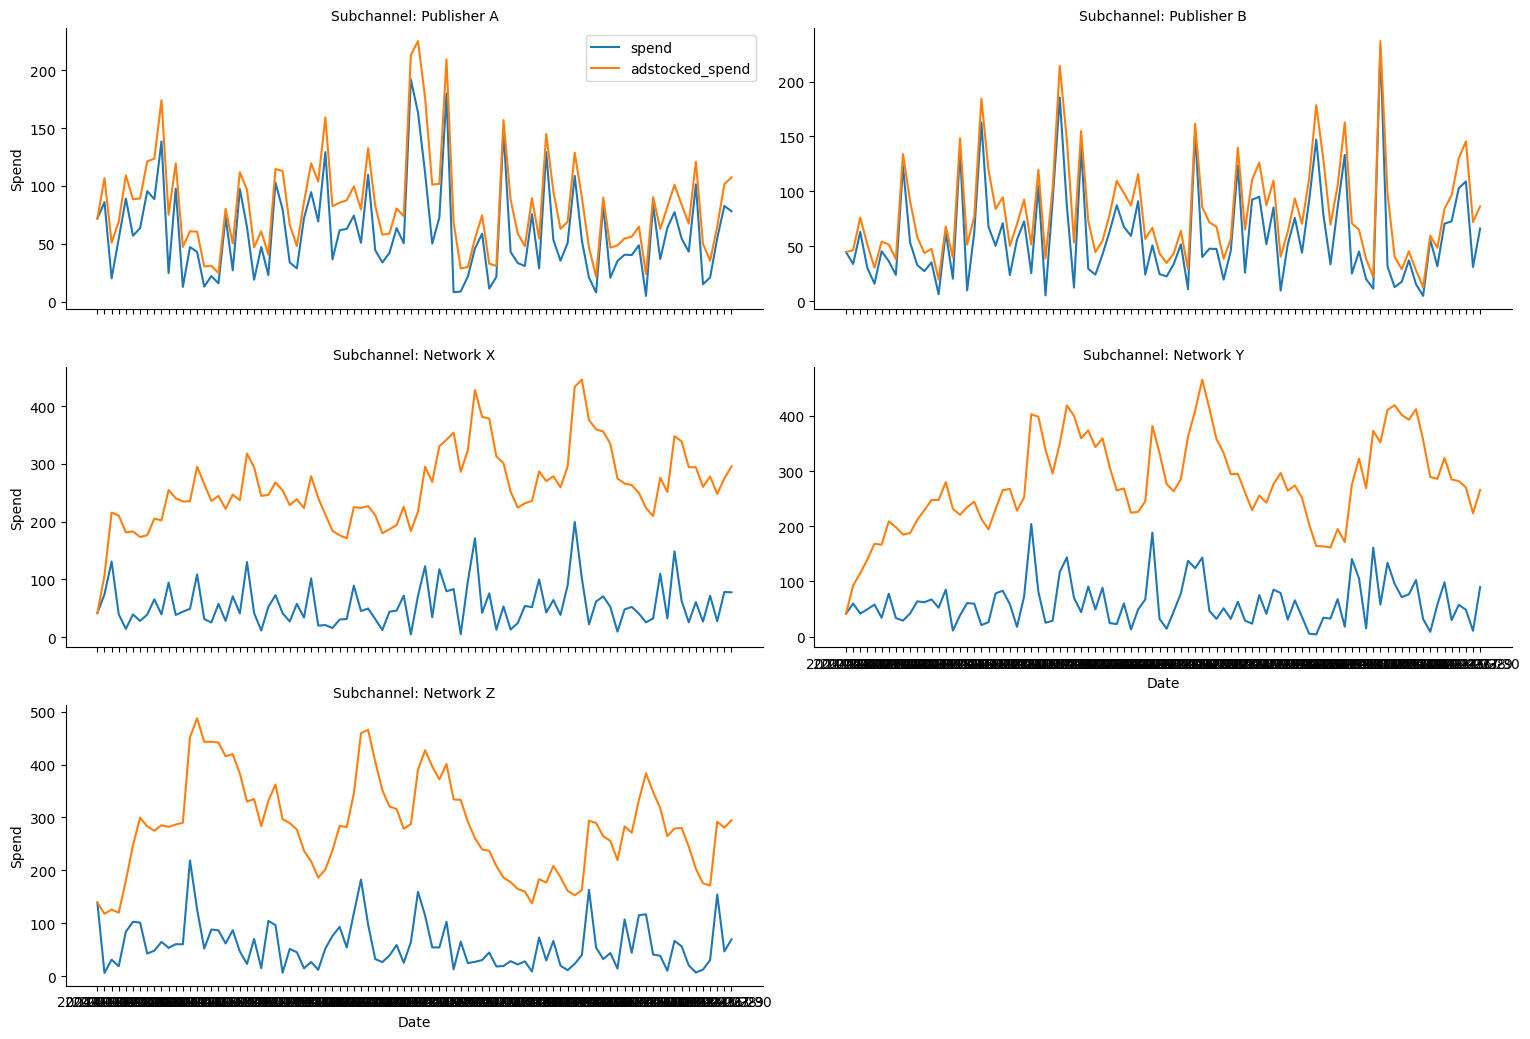

In [358]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Melt for long-form plotting with hue
df_plot = pd.melt(
    df_mini,
    id_vars=["date", "subchannel"],
    value_vars=["spend", "adstocked_spend"],
    var_name="type",
    value_name="value"
)

# Increase figure width for a wider chart
g = sns.FacetGrid(df_plot, col="subchannel", col_wrap=2, height=3.5, aspect=2.2, sharex=True, sharey=False)
g.map_dataframe(sns.lineplot, x="date", y="value", hue="type")

g.set_axis_labels("Date", "Spend")
g.set_titles("Subchannel: {col_name}")

# Only add one legend (not on every facet)
for ax in g.axes.flatten():
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, loc="best")
        break

g.tight_layout()
plt.show()

In [359]:

# Split spend by channel for adstock transformation
channel_names = df_mini["channel"].unique()
channel_to_idx = {name: i for i, name in enumerate(channel_names)}
df_mini["channel_idx"] = df_mini["channel"].map(channel_to_idx).astype(int)

subchannel_names = df_mini["subchannel"].unique()
subchannel_to_idx = {name: i for i, name in enumerate(subchannel_names)}
df_mini["subchannel_idx"] = df_mini["subchannel"].map(subchannel_to_idx).astype(int)


# Define X and Y

In [360]:
# Group spend data by subchannel
x_by_subchannel = []
obs_idx_by_subchannel = []

# Loop through unique subchannels to extract spend data and corresponding indices
for subchannel in df_mini["subchannel"].unique():
    subchannel_spend = df_mini[df_mini["subchannel"] == subchannel]["spend"].values  # Spend for this subchannel
    subchannel_indices = df_mini[df_mini["subchannel"] == subchannel].index.values  # Row indices in df_mini

    x_by_subchannel.append(subchannel_spend)
    obs_idx_by_subchannel.append(subchannel_indices)
    
# Prepare final inputs
y_daily = df_mini.groupby("date")["y"].first().sort_index().values
subchannel_idx = df_mini["subchannel_idx"].values
channel_idx = df_mini["channel_idx"].values
n_channels = len(channel_names)
print("n_channels:", n_channels)
n_subchannels = len(subchannel_names)
print("n_subchannels:", n_subchannels)

n_channels: 2
n_subchannels: 5


In [361]:
# Create mapping from subchannel to its parent channel index
subchannel_to_channel = (
    df_mini.drop_duplicates("subchannel")[["subchannel", "channel_idx"]]
    .set_index("subchannel")["channel_idx"]
    .to_dict()
)

# Create an array where each element is the channel_idx for the corresponding subchannel
channel_idx_for_each_subchannel = np.array([
    subchannel_to_channel[sub] for sub in subchannel_names
])

print("subchannel_to_channel:", subchannel_to_channel)
print("channel_idx_for_each_subchannel:", channel_idx_for_each_subchannel)

subchannel_to_channel: {'Publisher A': 0, 'Publisher B': 0, 'Network X': 1, 'Network Y': 1, 'Network Z': 1}
channel_idx_for_each_subchannel: [0 0 1 1 1]


# Run Model

In [ ]:


# Assume df_mini, subchannel_idx, channel_idx_for_each_subchannel, and y_daily are defined
# y_daily: vector of shape (n_days,) with one observed outcome per day (e.g., total sales per day)
# df_mini must have columns: "date", "subchannel", "spend"

coords = {
    "channel": ["Display", "Linear"],
    "subchannel": ["Publisher A", "Publisher B", "Network X", "Network Y", "Network Z"],
    "day": np.sort(df_mini["date"].unique()),
}

n_days = len(coords["day"])
n_subchannels = len(coords["subchannel"])

# Precompute for indexing
subchannel_to_idx = {name: i for i, name in enumerate(coords["subchannel"])}
day_to_idx = {date: i for i, date in enumerate(coords["day"])}

# Build spend matrix: shape (n_days, n_subchannels)
spend_matrix = np.zeros((n_days, n_subchannels))
for i, sub in enumerate(coords["subchannel"]):
    for j, day in enumerate(coords["day"]):
        mask = (df_mini["subchannel"] == sub) & (df_mini["date"] == day)
        if mask.any():
            spend_matrix[j, i] = df_mini.loc[mask, "spend"].values[0]

with pm.Model(coords=coords) as model:
    # Priors
    mu_adstock_alpha = pm.HalfNormal("mu_adstock_alpha", sigma=1, dims="channel")
    sigma_adstock_alpha = pm.HalfNormal("sigma_adstock_alpha", sigma=.2, dims="channel")

    channel_idx_for_each_subchannel = np.array(channel_idx_for_each_subchannel)  # Example, adjust as needed
    alpha = pm.TruncatedNormal(
        "adstock_alpha",
        mu=mu_adstock_alpha[channel_idx_for_each_subchannel],
        sigma=sigma_adstock_alpha[channel_idx_for_each_subchannel],
        lower=0,
        upper=1.0,
        dims="subchannel"
    )

    # Subchannel-level betas
    beta = pm.TruncatedNormal("beta", mu=0.2, sigma=0.05, lower=0, upper=.5, dims="subchannel")
    intercept = pm.Normal("intercept", mu=0, sigma=.5)
    sigma = pm.HalfNormal("sigma", sigma=.5)

    # Adstock calculation for each subchannel
    l_max = 64

    # Use pytensor to do the adstocking in the model
    adstocked = []
    for sub_idx in range(n_subchannels):
        spend_sub = spend_matrix[:, sub_idx]
        spend_sub_tt = pt.as_tensor_variable(spend_sub.astype(float))
        adstocked_sub = geometric_adstock(
            spend_sub_tt,
            alpha=alpha[sub_idx],
            l_max=l_max,
            normalize=False
        )
        adstocked.append(adstocked_sub)
    # Shape: (n_subchannels, n_days) -> transpose to (n_days, n_subchannels)
    adstocked = pt.stack(adstocked, axis=0).T  # shape (n_days, n_subchannels)

    # For each day, sum the contribution of all subchannels
    mu_per_day = intercept + pt.sum(beta * adstocked, axis=1)  # shape (n_days,)

    likelihood = pm.Normal("obs", mu=mu_per_day, sigma=sigma, observed=y_daily)

    trace = pm.sample(400, tune=400, nuts_sampler="pymc", return_inferencedata=True, target_accept=0.9)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_adstock_alpha, sigma_adstock_alpha, adstock_alpha, beta, intercept, sigma]


Output()

Sampling 4 chains for 400 tune and 400 draw iterations (1_600 + 1_600 draws total) took 12 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [363]:
import arviz as az # Output Results


# 1. Posterior Summary
print("Posterior Summary:")
summary = az.summary(trace, round_to=2).reset_index()
display(summary)

Posterior Summary:


,index,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,adstock_alpha[Publisher A],0.29,0.00,0.29,0.29,0.0,0.00,1375.43,1184.92,1.00
1,adstock_alpha[Publisher B],0.28,0.00,0.28,0.28,0.0,0.00,1147.93,1089.32,1.00
2,adstock_alpha[Network X],0.79,0.00,0.79,0.79,0.0,0.00,841.56,910.42,1.00
3,adstock_alpha[Network Y],0.79,0.00,0.79,0.79,0.0,0.00,850.62,1013.58,1.00
4,adstock_alpha[Network Z],0.80,0.00,0.80,0.80,0.0,0.00,958.79,1005.62,1.00
5,beta[Publisher A],0.10,0.00,0.10,0.10,0.0,0.00,1178.38,1140.94,1.00
6,beta[Publisher B],0.07,0.00,0.07,0.07,0.0,0.00,1177.71,908.46,1.00
7,beta[Network X],0.15,0.00,0.15,0.15,0.0,0.00,845.48,975.18,1.00
8,beta[Network Y],0.12,0.00,0.12,0.12,0.0,0.00,1187.23,1140.57,1.00
9,beta[Network Z],0.05,0.00,0.05,0.05,0.0,0.00,902.15,659.21,1.00


Plotting posterior distributions...


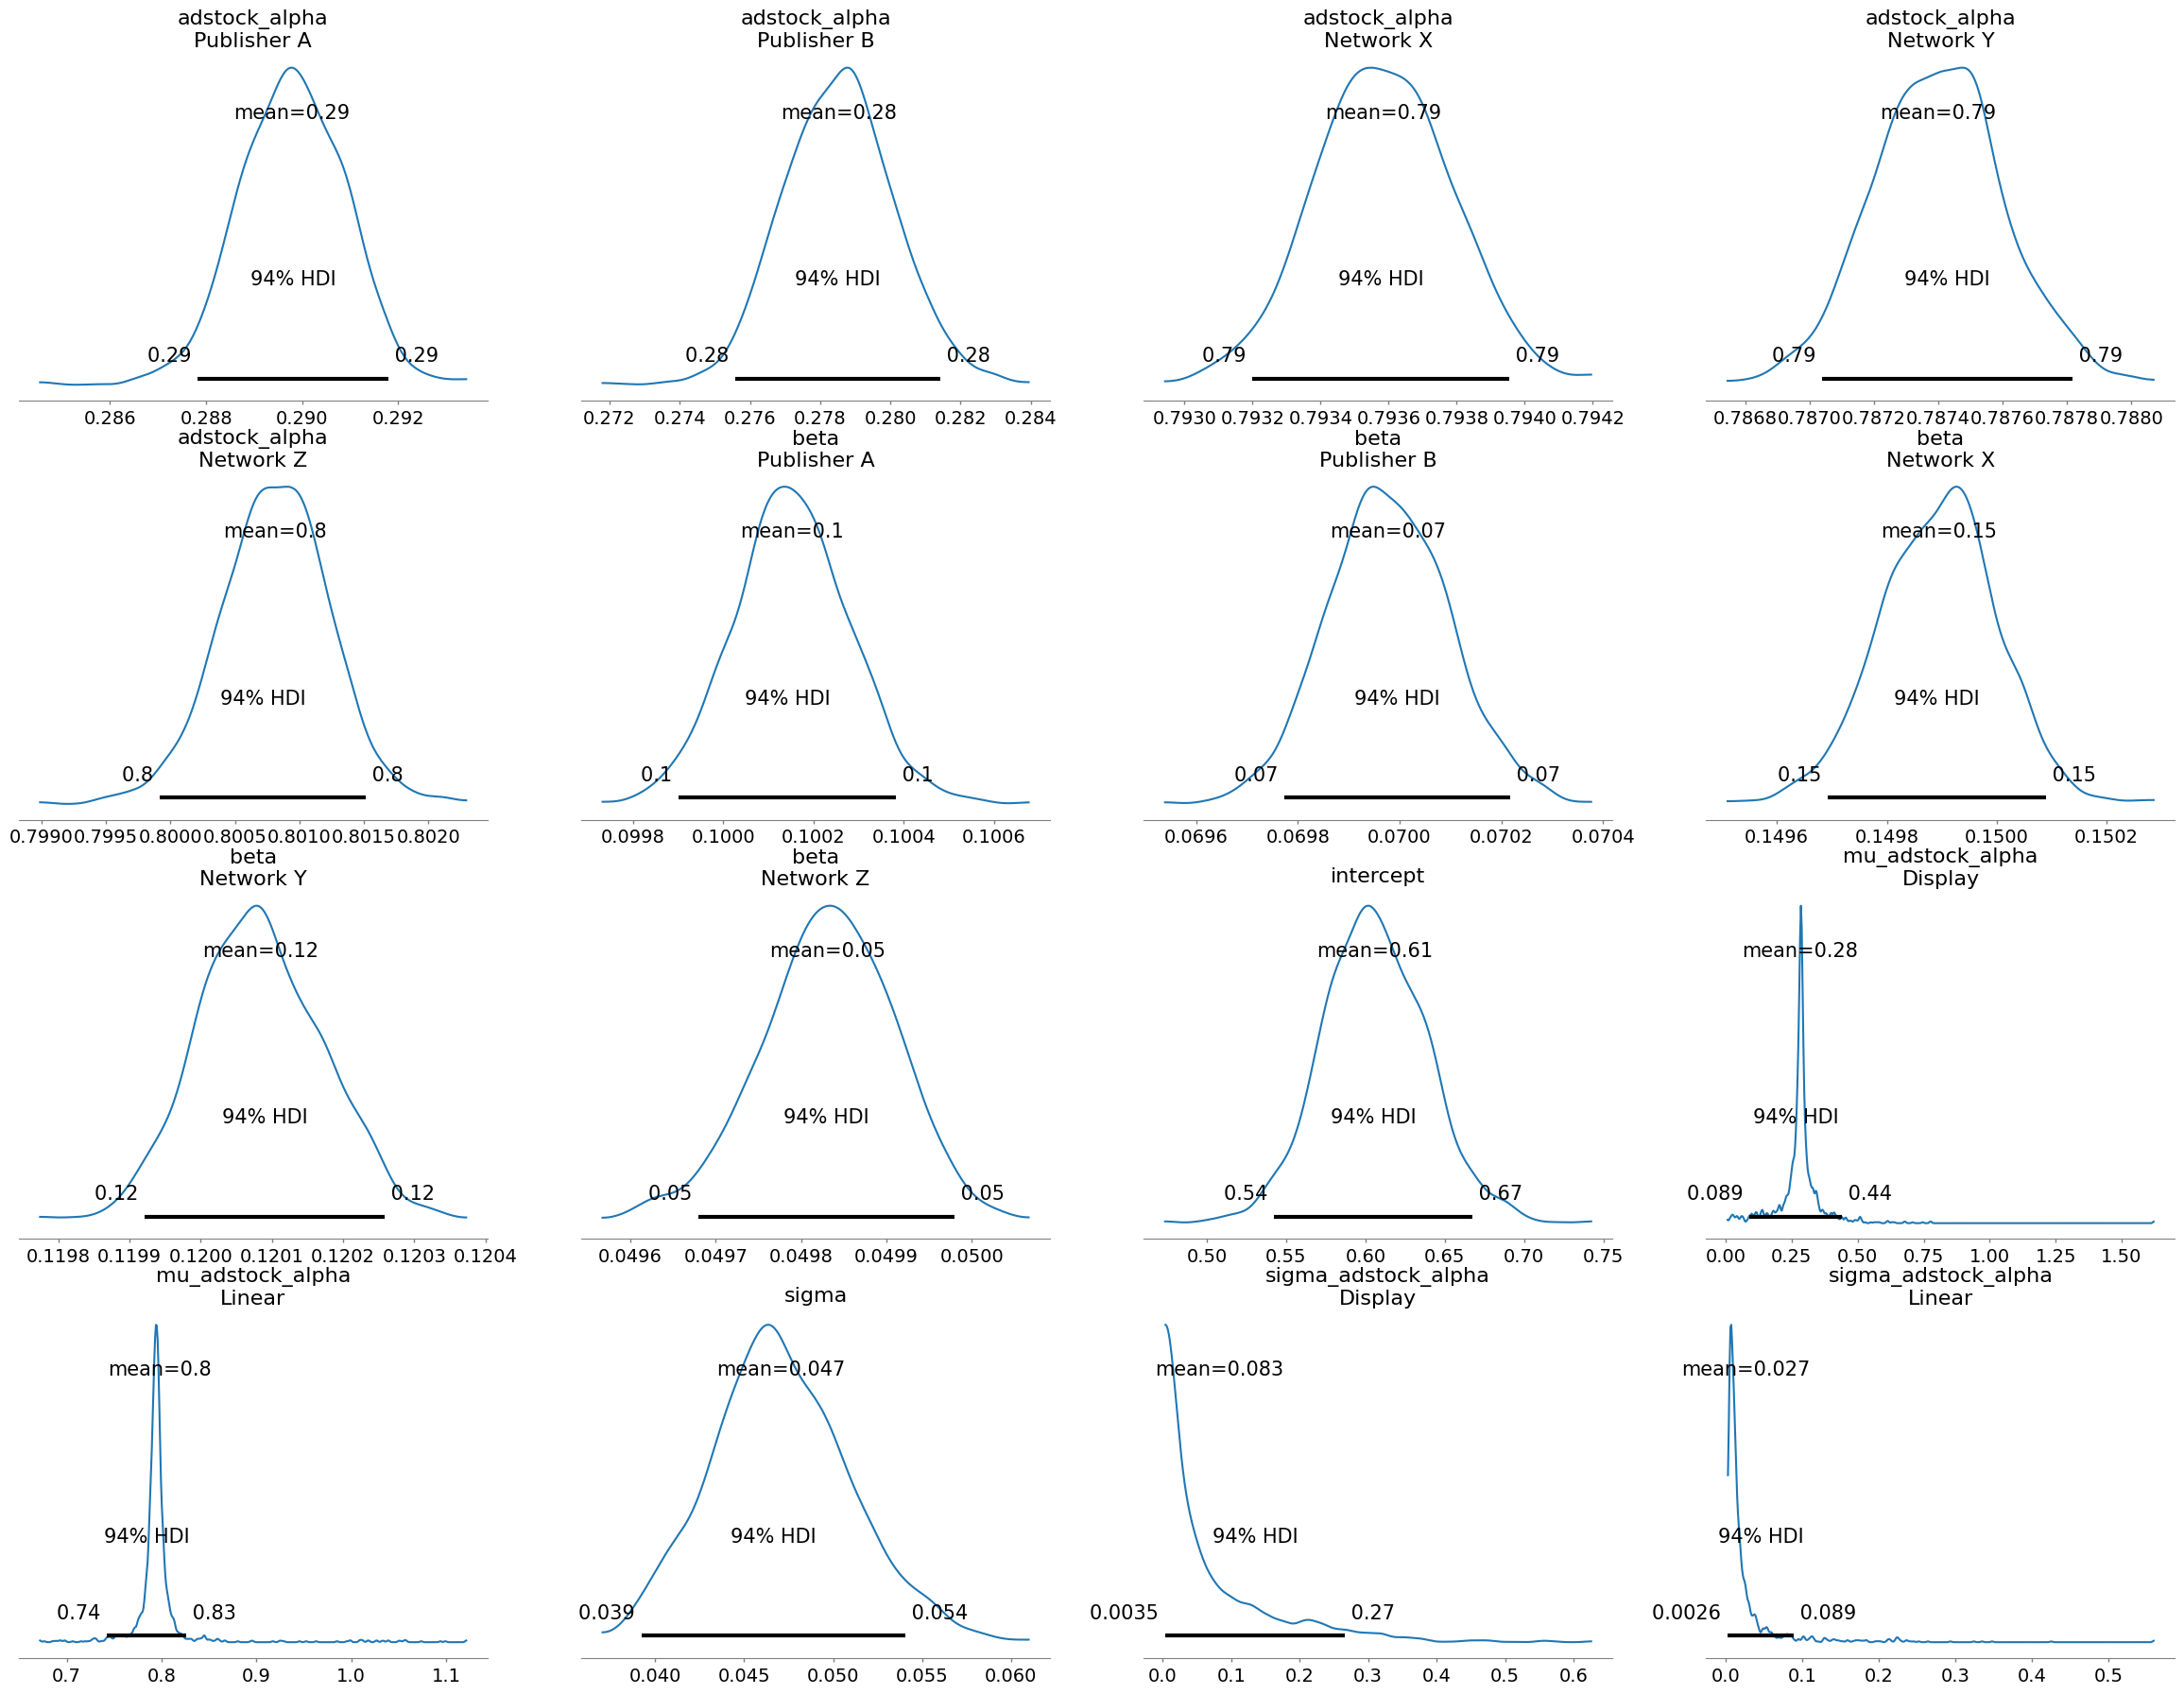

In [365]:


# Pass the dictionary to `var_names` to relabel the plots
print("Plotting posterior distributions...")
az.plot_posterior(trace)
plt.show()

Plotting trace plots...


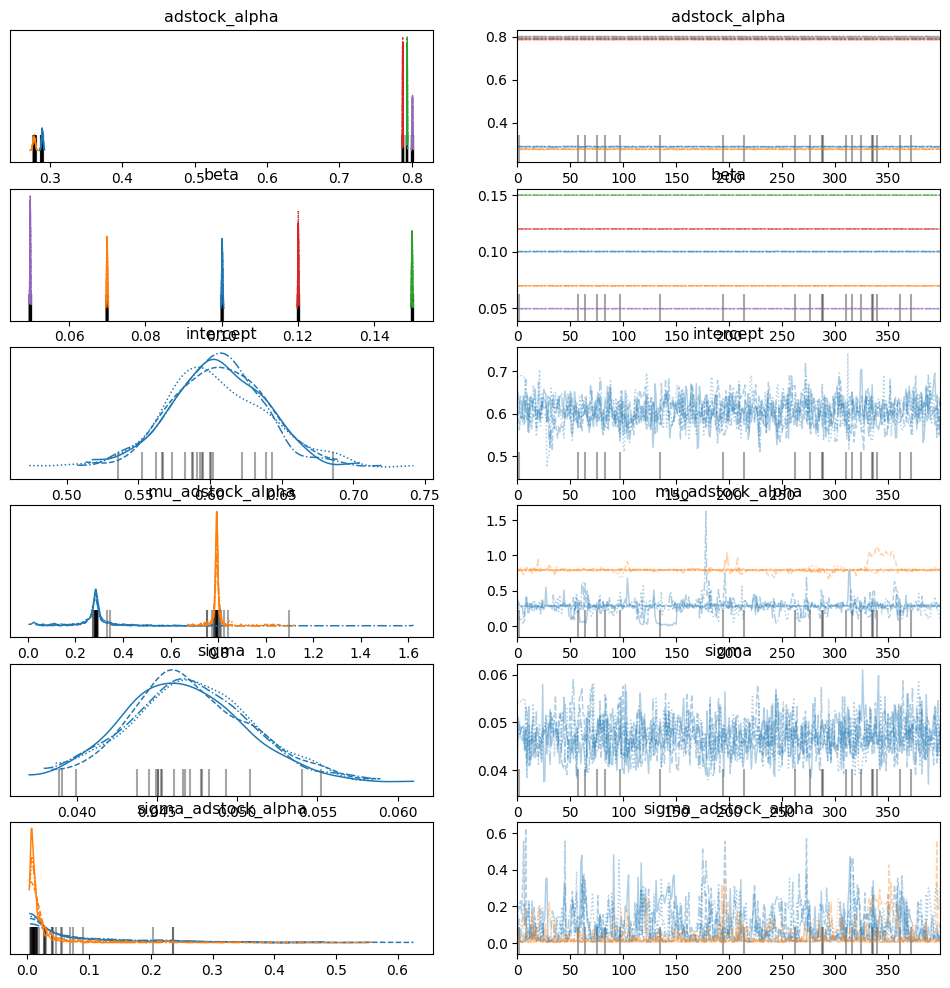

In [366]:
# 3. Trace Plots
print("Plotting trace plots...")
az.plot_trace(trace)
plt.show()

In [368]:
# Extract and Label Beta Coefficients
print("Beta Coefficients:")
beta_mean = trace.posterior["beta"].mean(dim=("chain", "draw"))
beta_std = trace.posterior["beta"].std(dim=("chain", "draw"))

# Map subchannel indices back to subchannel names
subchannel_mapping = {v: k for k, v in subchannel_to_idx.items()}

# Print labeled beta coefficients
for sub_idx, (mean, std) in enumerate(zip(beta_mean.values, beta_std.values)):
    subchannel_name = subchannel_mapping[sub_idx]
    print(f"Subchannel '{subchannel_name}': Mean = {mean:.3f}, Std = {std:.3f}")

# Save labeled beta coefficients to CSV
labeled_beta = pd.DataFrame({
    "Subchannel": [subchannel_mapping[i] for i in range(len(beta_mean))],
    "Beta_Mean": beta_mean.values,
    "Beta_Std": beta_std.values
})

display(labeled_beta)

Beta Coefficients:
Subchannel 'Publisher A': Mean = 0.100, Std = 0.000
Subchannel 'Publisher B': Mean = 0.070, Std = 0.000
Subchannel 'Network X': Mean = 0.150, Std = 0.000
Subchannel 'Network Y': Mean = 0.120, Std = 0.000
Subchannel 'Network Z': Mean = 0.050, Std = 0.000


,Subchannel,Beta_Mean,Beta_Std
0,Publisher A,0.100153,0.000129
1,Publisher B,0.069978,0.000119
2,Network X,0.149894,0.000108
3,Network Y,0.120084,0.000091
4,Network Z,0.049831,0.000080
